In [ ]:
from scipy.signal import butter, filtfilt

def denoise(signal, lowcut=0.5, highcut=40.0, fs=400.0, order=1):

    # Create a butterworth bandpass filter
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    # Apply the filter to the signal using filtfilt (forward-backward filter for zero-phase distortion)
    denoised_signal = filtfilt(b, a, signal)

    return denoised_signal

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

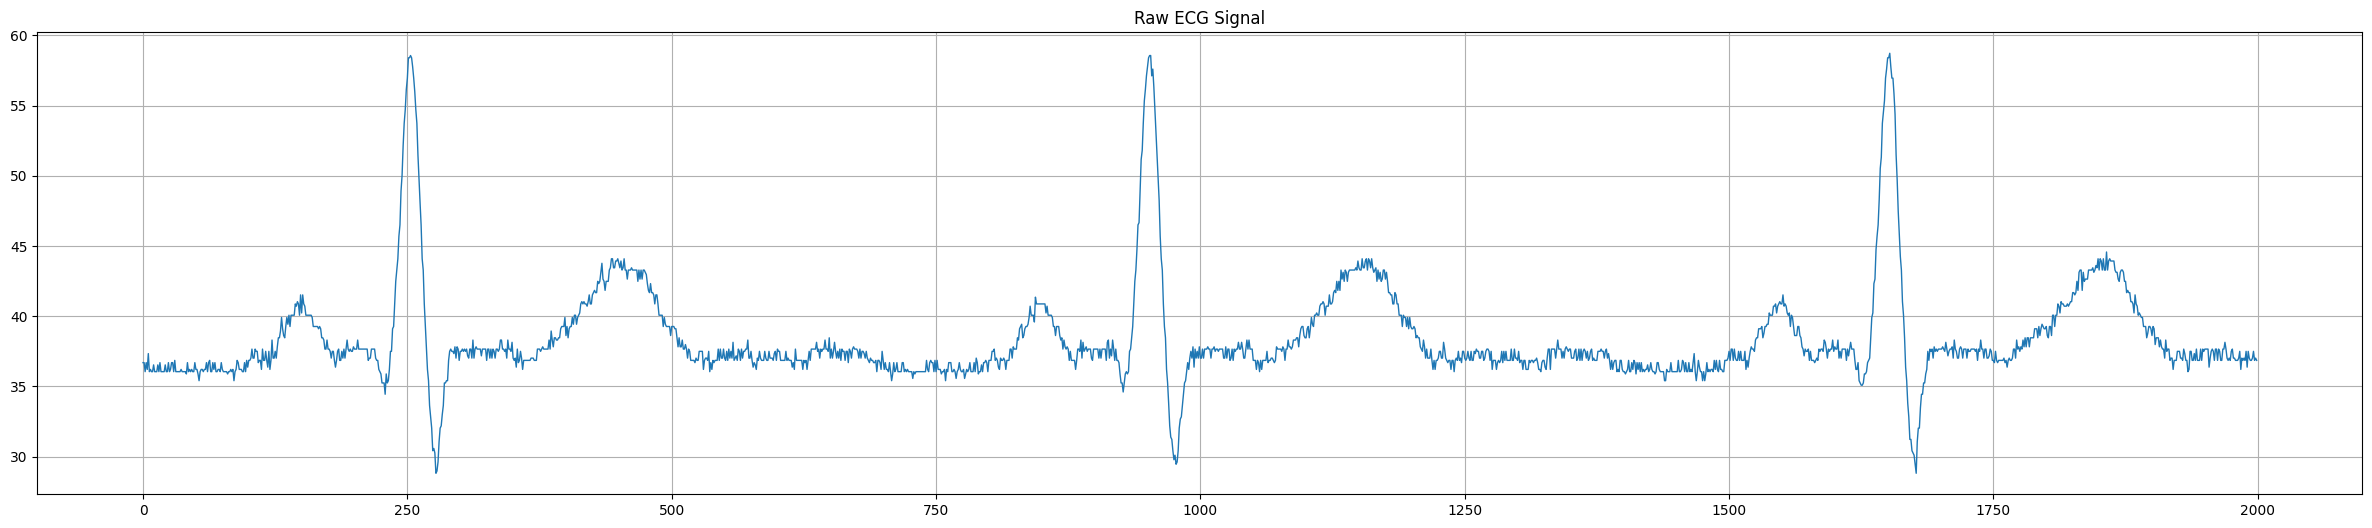

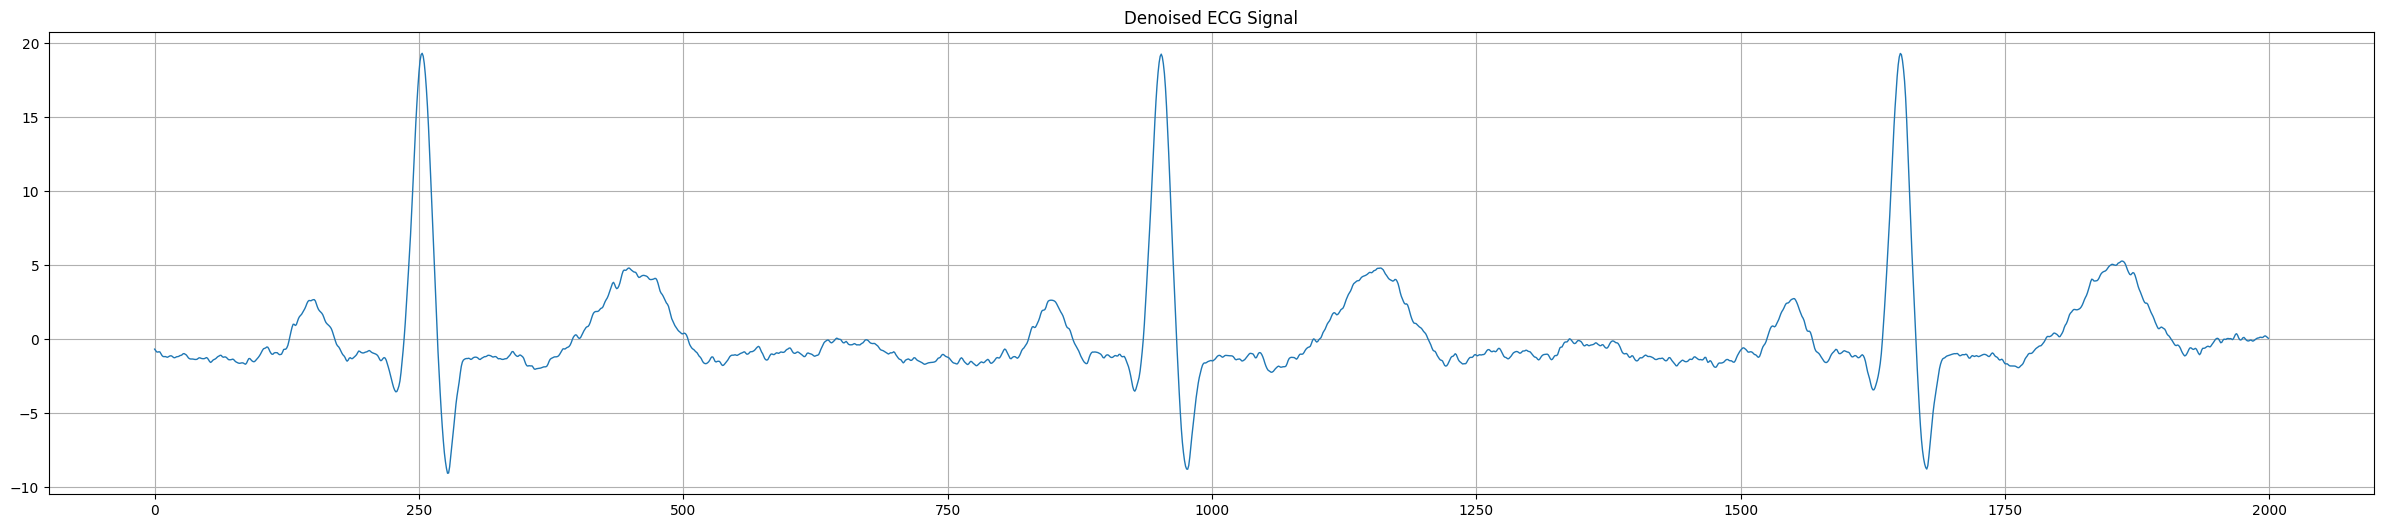

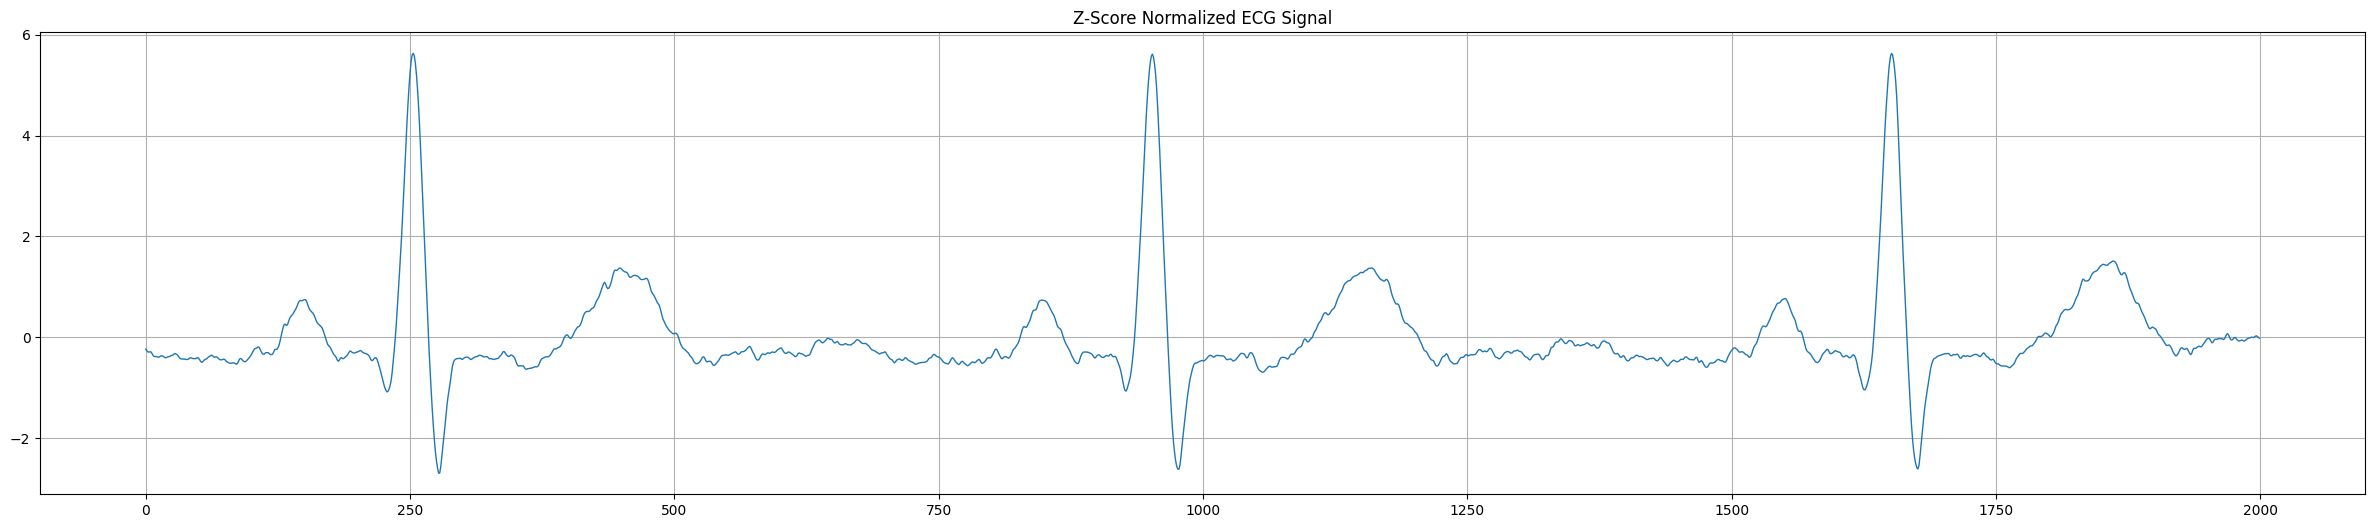

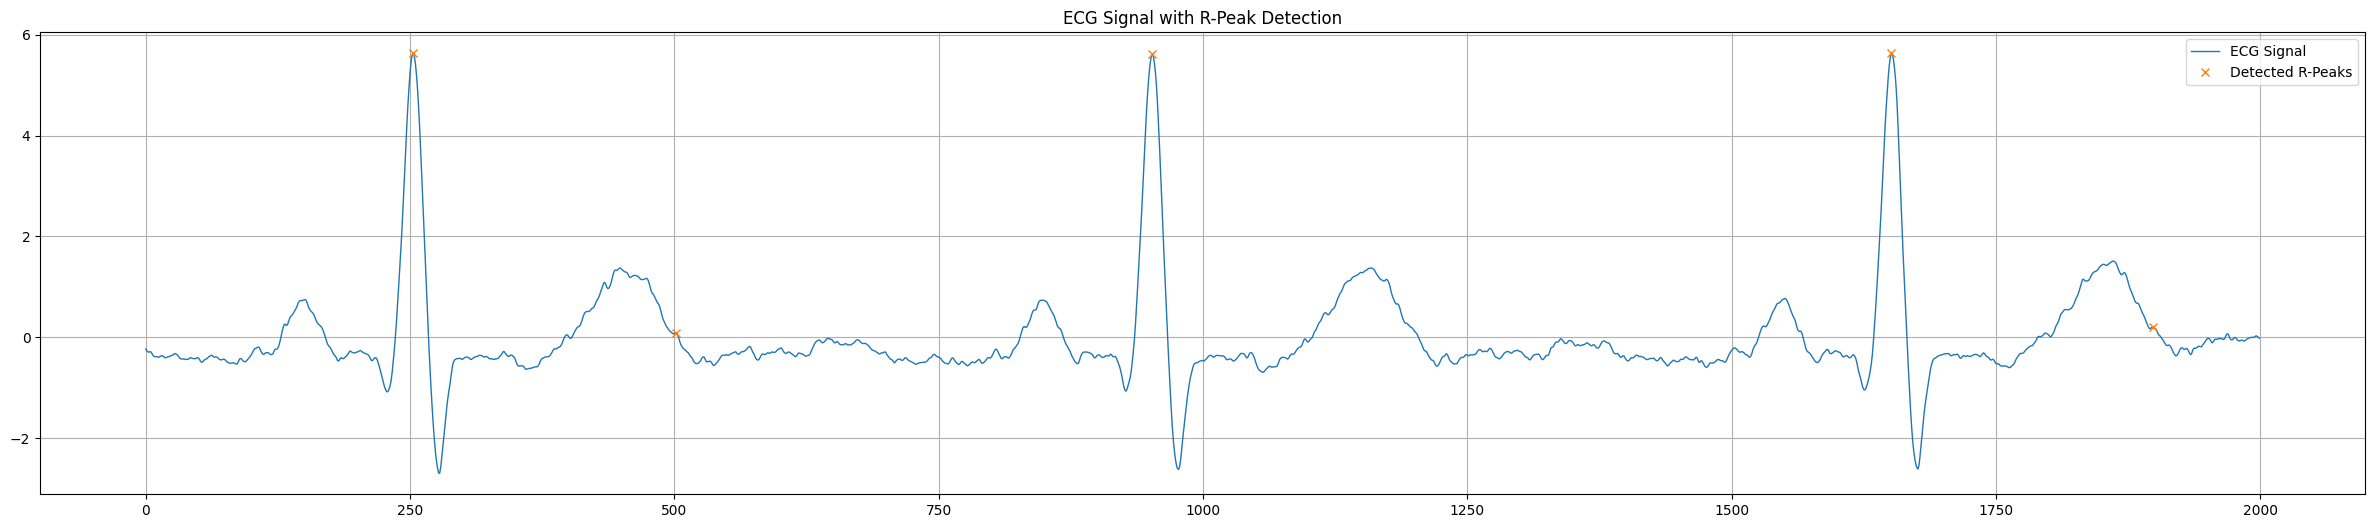

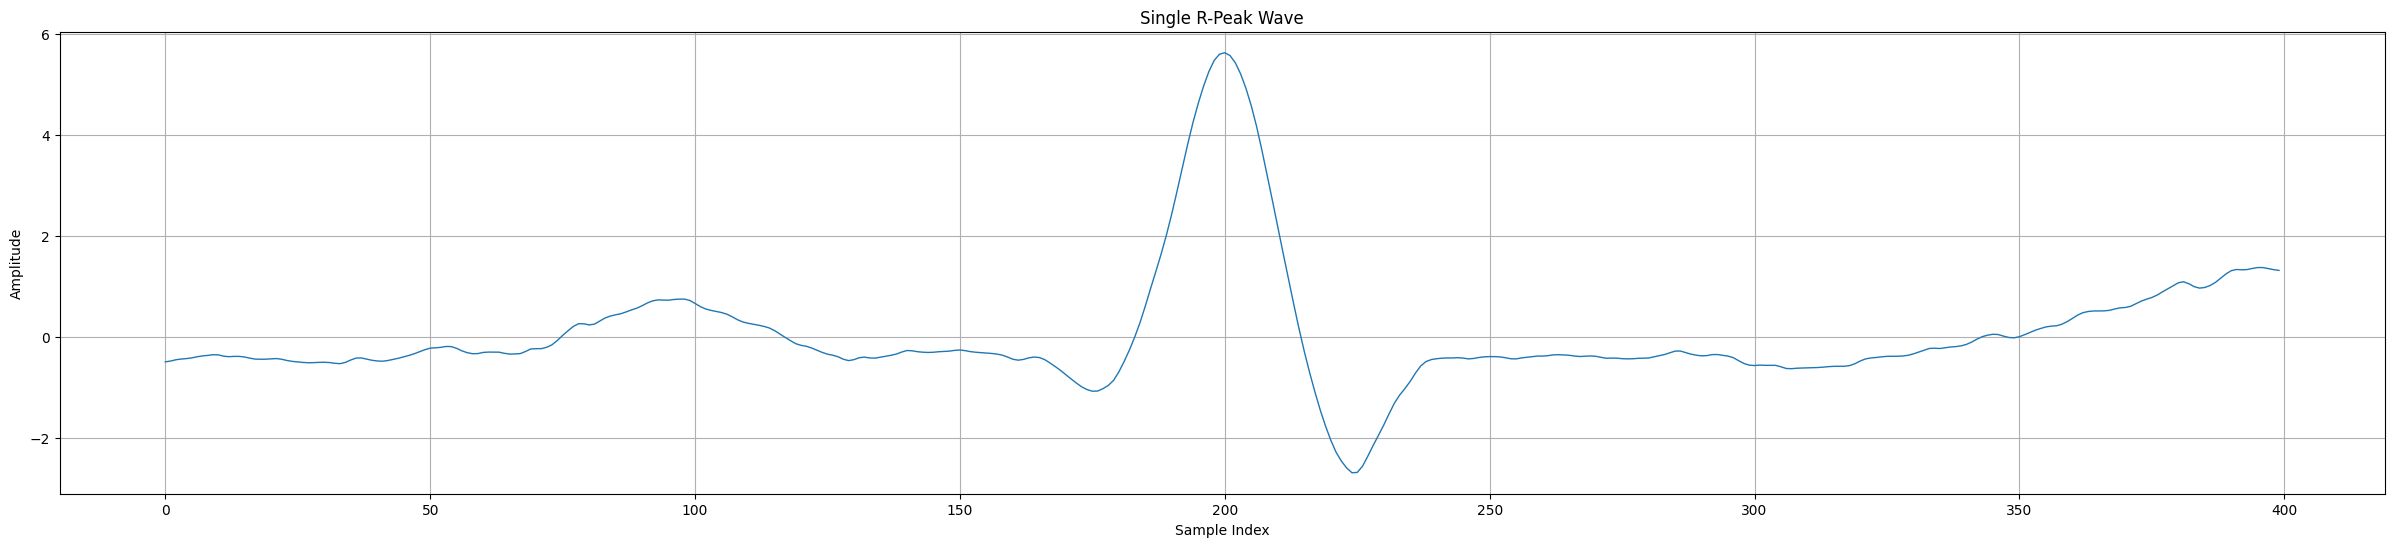

QRS complex saved to CSV file.
Shape of beats: (1600, 400)


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.signal import find_peaks

# Assuming you have a CSV file containing a single column of ECG signal data
file_path = 'raw_ecg.csv'  # Change to the actual file path

# Initialize an empty list to store the signal
signals = []

# Read the CSV file
with open(file_path, 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    row_index = -1
    for row in spamreader:
        if row_index >= 1:  # Skip header (if any)
            signals.append(float(row[1]))  # Assuming the signal is in the first column
        row_index += 1

# Convert the signal list to a numpy array
signals = np.array(signals)

# Plot the raw signal
plt.title("Raw ECG Signal")
plt.plot(signals[:])  # Plot the first 700 data points for visualization
plt.show()

# Denoise the signal (assuming `denoise` is your custom function)
signals = denoise(signals)

# Plot the denoised signal
plt.title("Denoised ECG Signal")
plt.plot(signals[:])  # Plot the first 700 data points for visualization
plt.show()

# Apply z-score normalization
signals = stats.zscore(signals)

# Plot the normalized signal
plt.title("Z-Score Normalized ECG Signal")
plt.plot(signals[:])  # [:700]Plot the first 700 data points for visualization
plt.show()

# Assuming that the sampling frequency is 360 Hz, which is typical for ECG signals
sampling_rate = 400.0
distance_between_peaks = int(0.6 * sampling_rate)  # Minimum distance between R-peaks (~600ms)

peaks, _ = find_peaks(signals, distance=distance_between_peaks, height=np.mean(signals))

# Plot the signal with detected R-peaks
plt.plot(signals[:2000], label="ECG Signal")  # Plot a segment of the signal
plt.plot(peaks[:10], signals[peaks[:10]], "x", label="Detected R-Peaks")  # Plot detected R-peaks
plt.legend()
plt.title("ECG Signal with R-Peak Detection")
plt.show()

window_size = 200  # Example window size (adjust as needed)

if len(peaks) > 0:
    peak_index = peaks[0]  # Change index to select a different peak if needed
    start = max(0, peak_index - window_size)
    end = min(len(signals), peak_index + window_size)
    r_peak_wave = signals[start:end]

    # Plot the R-peak wave
    plt.plot(r_peak_wave)
    plt.title("Single R-Peak Wave")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()
    qrs_complex = r_peak_wave
    # Pad or truncate the QRS complex to have exactly 360 samples
    if len(qrs_complex) < 360:
        # Padding with zeros
        qrs_complex = np.pad(qrs_complex, (0, 360 - len(qrs_complex)), 'constant')
    elif len(qrs_complex) > 360:
        # Truncating
        qrs_complex = qrs_complex[:360]
     # Save to CSV
    qrs_df = pd.DataFrame(qrs_complex, columns=['Amplitude'])
    qrs_df.to_csv('qrs_complex.csv', index=False)
    print("QRS complex saved to CSV file.")
else:
    print("No R-peaks detected.")
# Example: splitting signals into beats based on a fixed window size
beats = []

for i in range(window_size, len(signals) - window_size):
    beat = signals[i - window_size:i + window_size]  # Extract beat centered on index i
    beats.append(beat)

# Convert beats list to a numpy array for further processing
beats = np.array(beats)

# Print the shape of the preprocessed beats data
print("Shape of beats:", beats.shape)


(360, 1)


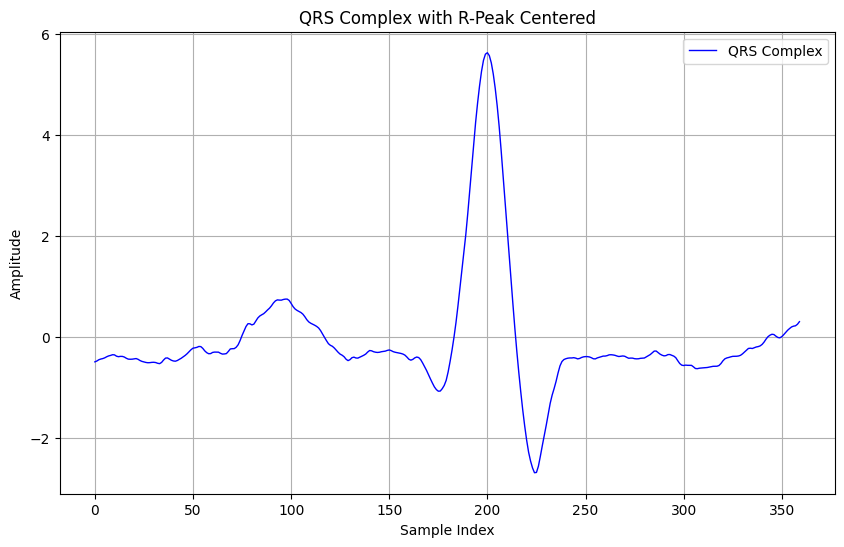

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = 'qrs_complex.csv'  # Change this to your actual path
qrs_data = pd.read_csv(csv_file_path)
print(qrs_data.shape)
# Generate x values (sample indices) from 0 to the length of the QRS complex
x_values = range(len(qrs_data))

# Plot the QRS complex
plt.figure(figsize=(10, 6))
plt.plot(x_values, qrs_data['Amplitude'], label='QRS Complex', color='b')
plt.title("QRS Complex with R-Peak Centered")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

import pandas as pd
import tensorflow as tf
import numpy as np

#Step 1: Load CSV file
csv_file = 'qrs_complex.csv'
data = pd.read_csv(csv_file)

#here the exported csv file has values in column wise, if it is in row format,
#then uncomment these lines.
"""# Select row index
row_index = 0
if row_index < data.shape[0]:
    my_sample = data.iloc[row_index].values
else:
    raise IndexError(f"Row {row_index} does not exist in the CSV file.")
"""
# Select column index
column_index = 0  # Change this index to choose a different column
if column_index < data.shape[1]:
    my_sample = data.iloc[:, column_index].values

#reshape
my_sample = my_sample.reshape(1, 360, 1)

# Step 4: Load the model
model = tf.keras.models.load_model('model.h5')

# Step 5: Run inference
result = model.predict(my_sample)
#print(result)

# Define the class labels
class_labels = ['N', 'L', 'R', 'A', 'V']

# Find the index of the maximum value in the prediction result
predicted_class_index = np.argmax(result)

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

# Print the predicted class
print(f"The predicted class is: {predicted_class}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
The predicted class is: N
